In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cPickle as cp
import sys
sys.path.append("../../utils")
from misc_utils import expected_loss
import os
from copy import deepcopy
from plotting_performance_vs_metric import get_closeness, get_log_closeness, get_spectrum
from plotting_performance_vs_metric import get_measurement_metric, get_performance_metric, average_results_array
from plotting_performance_vs_metric import get_nystrom_memory, get_rff_memory, get_cir_rff_memory
from plotting_performance_vs_metric import get_results_for_one_precision
import math

### plot performance v.s. approximation error

In [2]:
EPS = 1e-20

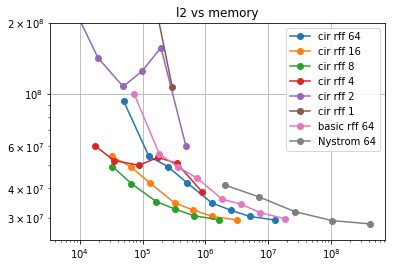

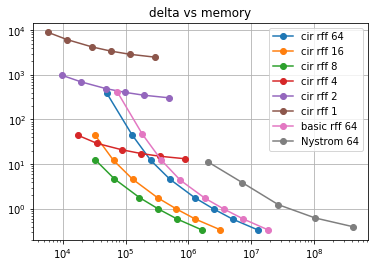

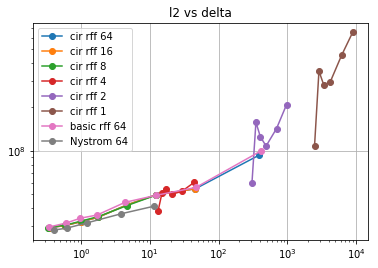

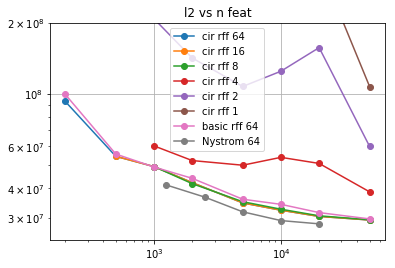

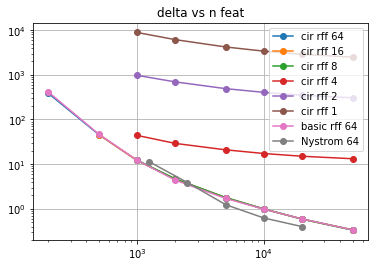

In [4]:
n_rff_feat_dict = {64: [200, 500, 1000, 2000, 5000, 10000, 20000, 50000],
           16: [500, 1000, 2000, 5000, 10000, 20000, 50000, ],
           8: [1000, 2000, 5000, 10000, 20000, 50000],
           4: [1000, 2000, 5000, 10000, 20000, 50000],
           2: [1000, 2000, 5000, 10000, 20000, 50000],
           1: [1000, 2000, 5000, 10000, 20000, 50000], }

m = 250
r = 119
# get results from cir rff runs
f_norm_dict_cir_rff = {}
l2_loss_list_cir_rff = {}
delta_list_cir_rff = {}
memory_list_cir_rff = {}
for nbit in [64, 16, 8, 4, 2, 1]:
    rff_mem_func = lambda n : get_cir_rff_memory(n, m, r, nbit)

    n_rff_feat = n_rff_feat_dict[nbit]
    general_folder_measurement = "/dfs/scratch0/zjian/lp_kernel/lp_rff/regression_real_setting"
    general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/lp_rff/regression_real_setting"
    general_folder_delta = "/dfs/scratch0/zjian/lp_kernel/lp_rff/regression_real_setting"
    folder_pattern = "census_type_cir_rff_l2_reg_0.0005_n_feat_unk_n_bit_" + str(nbit) + "_seed_unk"
    f_norm_list, l2_loss_list, delta_list = \
        get_results_for_one_precision(n_rff_feat, general_folder_measurement, 
                                      general_folder_performance, general_folder_delta,
                                      folder_pattern=folder_pattern, seeds=[1,2,3,4,5] )
    memory_list = [rff_mem_func(x) for x in n_rff_feat]
    f_norm_dict_cir_rff[nbit] = deepcopy(f_norm_list)
    l2_loss_list_cir_rff[nbit] = deepcopy(l2_loss_list)
    delta_list_cir_rff[nbit] = deepcopy(delta_list)
    memory_list_cir_rff[nbit] = deepcopy(memory_list)
    
#     print "cir ", nbit
#     print f_norm_list
#     print l2_loss_list
#     print delta_list
#     print memory_list
    
# get results from fp nystrom runs
nystrom_mem_func = lambda n : get_nystrom_memory(n, m, r)
n_nystrom_feat = [1250, 2500, 5000, 10000, 20000]
general_folder_measurement = "/dfs/scratch0/zjian/lp_kernel/closeness/regression_real_setting"
general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/closeness/regression_real_setting"
general_folder_delta = "/dfs/scratch0/zjian/lp_kernel/symmetric_delta/regression_real_setting"
folder_pattern = "census_type_nystrom_l2_reg_0.0005_n_fp_feat_unk_seed_unk"
f_norm_list_nystrom, l2_loss_list_nystrom, delta_list_nystrom = \
    get_results_for_one_precision(n_nystrom_feat, general_folder_measurement, 
                                  general_folder_performance, general_folder_delta,
                                  folder_pattern=folder_pattern, seeds=[1,2,3,] )
memory_list_nystrom = [nystrom_mem_func(x) for x in n_nystrom_feat]
    
# get results from basic rff runs
rff_mem_func = lambda n : get_rff_memory(n, m, r)
n_rff_feat = n_rff_feat_dict[64]
general_folder_measurement = "/dfs/scratch0/zjian/lp_kernel/lp_rff/regression_real_setting"
general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/lp_rff/regression_real_setting"
general_folder_delta = "/dfs/scratch0/zjian/lp_kernel/lp_rff/regression_real_setting"
folder_pattern = "census_type_rff_l2_reg_0.0005_n_feat_unk_n_bit_" + str(64) + "_seed_unk"
f_norm_list_rff, l2_loss_list_rff, delta_list_rff = \
    get_results_for_one_precision(n_rff_feat, general_folder_measurement, 
                                  general_folder_performance, general_folder_delta,
                                  folder_pattern=folder_pattern, seeds=[1,2,3,4,5] )
memory_list_rff = [rff_mem_func(x) for x in n_rff_feat]
# print "basic", nbit
# print f_norm_list_rff
# print l2_loss_list_rff
# print delta_list_rff
# print memory_list_rff

plt.figure()
for nbit in [64, 16, 8, 4, 2, 1]:
    plt.plot(memory_list_cir_rff[nbit], l2_loss_list_cir_rff[nbit], "-o", label="cir rff " + str(nbit) )
plt.plot(memory_list_rff, l2_loss_list_rff, "-o", label="basic rff " + str(64) )    
plt.plot(memory_list_nystrom, l2_loss_list_nystrom, "-o", label="Nystrom " + str(64) )    
plt.grid()
plt.yscale("log")
plt.xscale("log")
plt.title("l2 vs memory")
plt.legend()
plt.ylim([None, 2e8])
plt.show()

plt.figure()
for nbit in [64, 16, 8, 4, 2, 1]:
    plt.plot(memory_list_cir_rff[nbit], delta_list_cir_rff[nbit], "-o", label="cir rff " + str(nbit) )
plt.plot(memory_list_rff, delta_list_rff, "-o", label="basic rff " + str(64) )    
plt.plot(memory_list_nystrom, delta_list_nystrom, "-o", label="Nystrom " + str(64) )    
plt.grid()
plt.yscale("log")
plt.xscale("log")
plt.title("delta vs memory")
plt.legend()
# plt.ylim([None, 2e8])
plt.show()

plt.figure()
for nbit in [64, 16, 8, 4, 2, 1]:
    plt.plot(delta_list_cir_rff[nbit], l2_loss_list_cir_rff[nbit], "-o", label="cir rff " + str(nbit) )
plt.plot(delta_list_rff, l2_loss_list_rff, "-o", label="basic rff " + str(64) )  
plt.plot(delta_list_nystrom, l2_loss_list_nystrom, "-o", label="Nystrom " + str(64) )    
plt.grid()
plt.yscale("log")
plt.xscale("log")
plt.title("l2 vs delta")
plt.legend()
# plt.ylim([None, 2e8])
plt.show()


plt.figure()
for nbit in [64, 16, 8, 4, 2, 1]:
    plt.plot(n_rff_feat_dict[nbit], l2_loss_list_cir_rff[nbit], "-o", label="cir rff " + str(nbit) )
plt.plot(n_rff_feat_dict[64], l2_loss_list_rff, "-o", label="basic rff " + str(64) )    
plt.plot(n_nystrom_feat, l2_loss_list_nystrom, "-o", label="Nystrom " + str(64) )    
plt.grid()
plt.yscale("log")
plt.xscale("log")
plt.title("l2 vs n feat")
plt.legend()
plt.ylim([None, 2e8])
plt.show()

plt.figure()
for nbit in [64, 16, 8, 4, 2, 1]:
    plt.plot(n_rff_feat_dict[nbit], delta_list_cir_rff[nbit], "-o", label="cir rff " + str(nbit) )
plt.plot(n_rff_feat_dict[64], delta_list_rff, "-o", label="basic rff " + str(64) )    
plt.plot(n_nystrom_feat, delta_list_nystrom, "-o", label="Nystrom " + str(64) )    
plt.grid()
plt.yscale("log")
plt.xscale("log")
plt.title("delta vs n feat")
plt.legend()
# plt.ylim([None, 2e8])
plt.show()